First, let's download a picture in binary mode. To make it simple, I'm downloading it from the MNIST dataset in keras.

In [13]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

We only want one picture for simplification. Let's call it our variable.

In [18]:
variable = x_train[0]

Let's check how the picture looks like. First let's get its dimensions, and the value of the brightest pixel.

In [19]:
dimension1 = variable.shape[0]
dimension2 = variable.shape[1]
brightest_pixel = variable.max()

print(dimension1, dimension2)
print(brightest_pixel)

28 28
255


As you can see. We'll have 28 * 28 = 784 pixel numbers, and the maximum value of those numbers is 255. Let's check how 255 would look like in binary form.

In [49]:
binary_format = bin(brightest_pixel)[2:]
print(binary_format)

11111111


Let's get the length of that string.

In [29]:
binary_format_length = len(binary_format)
print(binary_format_length)

8


In essense, we could transform all the pixel numbers in the image into 8-digit binary numbers. We thus would have a 8 * 28 * 28 array. Let's call this our "gene_length".

In [30]:
gene_length = binary_format_length * dimension1 * dimension2
print(gene_length)

6272


Let's check how the image looks like using pyplot.

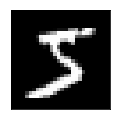

In [371]:
import matplotlib.pyplot as plt

def show_picture(variable):
    plt.figure(figsize=(20, 4))

    # display original
    ax = plt.subplot(2, 1, 1)
    plt.imshow(variable.reshape(variable.shape[0], variable.shape[1]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    plt.show()
    
show_picture(variable)

Clearly, it's a 5. But let's transform each and every pixel into a binary number first. Let's make a function to transform an image into binary and the binaries back to an image.

In [158]:
def transform_image_to_binary(image, binary_format_length):
    
    #Flatten the 28x28 array into 784x1
    image = image.flatten()
    
    #Transform every number into a binary format
    image = np.array([bin(i)[2:].zfill(binary_format_length) for i in image])
    
    #Make a list of binaries
    binaries = list()
    for i in image:
        for j in i:
            binaries.append(int(j))
    
    binaries = np.array(binaries)
    
    return binaries

def transform_binary_to_image(binaries, binary_format_length):
    
    #Reshape the numbers in groups of 8
    binaries = binaries.reshape(-1,8)
    
    #Join the groups and read the numbers
    image = list()
    for i in range(len(binaries)):
        number = ''.join(str(j) for j in binaries[i])
        number = int(number, 2)
        image.append(number)
    
    #Reshape the picture in a 28x28 array
    image = np.array(image)
    image = image.reshape(28, 28)
    
    return image

Let's test to see if the two functions work.

In [ ]:
transformed_image = transform_image_to_binary(variable, binary_format_length)
reconstructed_image = transform_binary_to_image(transformed_image, binary_format_length)
reconstructed_image == variable

All right, since we have our target variable specifications sorted out, and possible transformations. Let's move on to designing our Evolutionary Algorithm. Let's first define a function to generate a random individual.

In [34]:
def generate_individual(gene_length):
    return np.random.randint(2, size = gene_length, dtype = 'uint')

In [40]:
test_individual = generate_individual(gene_length)
print(test_individual)
print(len(test_individual))

[0 0 0 ... 1 0 0]
6272


Looks like it works. Now let's generate a population of them.

In [45]:
def generate_population(population_size, gene_length):
    population = list()
    for i in range(population_size):
        population.append(generate_individual(gene_length))
    return population

In [47]:
test_population = generate_population(10, gene_length)
print(test_population)
print(len(test_population))

[array([0, 1, 0, ..., 1, 1, 1], dtype=uint32), array([0, 1, 0, ..., 1, 1, 0], dtype=uint32), array([0, 0, 0, ..., 0, 0, 0], dtype=uint32), array([0, 1, 1, ..., 1, 1, 1], dtype=uint32), array([1, 1, 0, ..., 0, 0, 1], dtype=uint32), array([1, 1, 1, ..., 1, 1, 0], dtype=uint32), array([0, 1, 0, ..., 1, 1, 1], dtype=uint32), array([0, 1, 1, ..., 0, 1, 0], dtype=uint32), array([0, 0, 0, ..., 1, 0, 0], dtype=uint32), array([1, 0, 1, ..., 1, 1, 1], dtype=uint32)]
10


Looks like it's all good. With a population generated, let's see how we'll evaluate each individual. First, let's define what we are trying to minimize. Let's call it error, which is the sheer number of binary numbers that are wrong.

In [184]:
def error_score(individual, variable):
    error = sum(individual != transform_image_to_binary(variable, binary_format_length))
    return error

Let's compile all errors into a list of results.

In [268]:
def score_results(population, variable):
    results = list()
    for i in range(len(population)):
        error = error_score(population[i], variable)
        results.append([i, error])
    results = np.array(results)
    results = pd.DataFrame(results).sort_values(by = 1)
    results = results.values
    return results

Let's see what we get.

In [269]:
results = score_results(test_population, variable)

In [276]:
results

array([[   9, 3078],
       [   7, 3100],
       [   3, 3104],
       [   8, 3105],
       [   6, 3138],
       [   5, 3142],
       [   4, 3163],
       [   2, 3164],
       [   1, 3204],
       [   0, 3248]])

Now, let's make several components of the selection process.

In [ ]:
from math import ceil

def survival_of_the_fittest(population, results, top_percentile = 0.2, lucky_few = 0.1):
    population_size = len(population)
    top_percentile = ceil(top_percentile * population_size)
    survivors = results[:top_percentile,0]
    survivors = [population[i] for i in survivors]
    rest = results[top_percentile:,0]
    rest = [population[i] for i in rest]
    lucky_few = ceil(len(rest) * lucky_few)
    for lucky in range(lucky_few):
        survivors.append(rest[np.random.randint(0,len(rest))])
    return survivors

def matching(survivors, population):
    population_size = len(population)
    prob = np.array(range(len(survivors))) + 1
    prob = prob/sum(prob)
    prob = sorted(prob, reverse = True)
    position_range = np.array(range(len(survivors)))
    position_range = np.random.choice(position_range, population_size * 2, p = prob)
    matches = [survivors[ind] for ind in position_range]
    return matches

def children(matches, gene_length):
    children = list()
    for i in range(0,int(len(matches)/2)):
        j = i * 2
        i = j + 1
        c = breeding(matches[j], matches[i], gene_length)
        children.append(c)
    return children

def breeding(a, b, gene_length):
    binn = np.random.randint(2, size = gene_length, dtype = 'uint')
    c = np.zeros(gene_length, dtype = 'uint')
    for i in range(gene_length):
        if binn[i] == 0: c[i] = mutate(a[i])
        else: c[i] = mutate(b[i])
    return c

def mutate(gene):
    prob = 1/gene_length
    prob = 0.1
    mutation = np.random.randint(2)
    gene = np.random.choice([gene, mutation], p = [1-prob, prob])
    return gene

def new_generation(population, variable, gene_length):
    results = score_results(population, variable)
    survivors = survival_of_the_fittest(population, results)
    matches = matching(survivors, population)
    population = children(matches, gene_length)
    return population

In order to track the time of each generation, I've written a very basic "time_delta" function.

In [342]:
import time, datetime
def time_delta(temp_start_time):
    delta = time.time() - temp_start_time
    return str(datetime.timedelta(seconds=int(delta)))

Finally, let's compile everything in a single function.

In [349]:
def evolutionary_algorithm(variable, population_size, number_of_rounds):
    
    dimension1 = variable.shape[0]
    dimension2 = variable.shape[1]
    brightest_pixel = variable.max()
    gene_length = binary_format_length * dimension1 * dimension2
    
    population = generate_population(population_size, gene_length)
    
    for i in range(number_of_rounds):
        temp_start_time = time.time()
        population = new_generation(population, variable, gene_length)
        score = score_results(population, variable)[0][1]
        print(score, time_delta(temp_start_time), '\n')
    
    winner = population[score_results(population, variable)[0][0]]
    winner = transform_binary_to_image(winner, binary_format_length)
    
    return winner, population, score

Now we just need to set the parameters and sit tight.

In [360]:
winner, population, score = evolutionary_algorithm(variable, 200, 10)

2990 0:00:42 

2953 0:00:40 

2910 0:00:40 

2869 0:00:41 

2829 0:00:40 

2795 0:00:41 

2769 0:00:40 

2714 0:00:40 

2666 0:00:44 

2646 0:00:42 



In [376]:
def continue_evolution(variable, population, population_size, number_of_rounds):
    
    for i in range(number_of_rounds):
        temp_start_time = time.time()
        population = new_generation(population, variable, gene_length)
        score = score_results(population, variable)[0][1]
        print(i, score, time_delta(temp_start_time), '\n')
    
    winner = population[score_results(population, variable)[0][0]]
    winner = transform_binary_to_image(winner, binary_format_length)
    
    return winner, population, score

In [ ]:
winner, population, score = continue_evolution(variable, population, 200, 100)

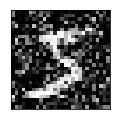

In [379]:
show_picture(winner)